In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Libs**

In [38]:
import numpy as np
import random
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error #mean_squared_error(y,y_pred, squared=True)
from sklearn.metrics import mean_absolute_error #mean_absolute_error(y,y_pred)
from sklearn.preprocessing import StandardScaler

**Random Optimizer**

In [102]:
def randomOptimizer(X, y_true, iterations):
  w1=[]
  w2=[]
  b=[]
  weight_range = 5
  for i in range(iterations):
    w1.append(randint(-weight_range, weight_range)+random.random())
    w2.append(randint(-weight_range, weight_range)+random.random())
    b.append(randint(-weight_range, weight_range)+random.random())

  RSME=[]
  MAE=[]
  y_pred_list=[]
  for i in range(iterations):
    y_pred_list.append(X[:,0]*w1[i] + X[:,1]*w2[i] + b[i]) #X1*w1 + X2*w2 + b
    RSME.append(mean_squared_error(y_true,y_pred_list[i], squared=True))
    MAE.append(mean_absolute_error(y_true,y_pred_list[i]))

  pos = [np.argmin(MAE), np.argmin(RSME)]

  return min(MAE), y_pred_list[pos[0]]

**Linear Regression**

In [59]:
# Define the neural network function y = x * w
def nn(X, w):
    return X.dot(w)

def activation(y):
    z = y
    return z

# Define the cost function
def cost(y_pred, y_true):
    xi = (0.5*(y_pred - y_true)**2).sum()
    return xi

# define the gradient function. Remember that y = nn(x, w) = x * w
def gradient(w, X, y_true):
    gradient = X * (activation(nn(X, w).reshape(252,1)) - y_true)
    #print("Gradient: ",gradient)
    return gradient

# define the update function delta w. Batch formula
def delta_w(w, X, y_true, learning_rate):
    delta_w = learning_rate * gradient(w, X, y_true).sum()
    #print("Delta W: ",delta_w)
    return delta_w

def batch_train(X, y_true, weights, learning_rate):
  # Start performing the gradient descent updates, and print the weights and cost:  
  w_cost = []
  w_cost.append(cost(nn(X, weights), y_true)) # List to store the costs

  nb_of_iterations = 100

  for i in range(nb_of_iterations):
      dw = delta_w(weights, X, y_true, learning_rate)  # Get the delta w update
      weights = weights - dw  # Update the current weight parameter
      w_cost.append(cost(activation(nn(X, weights)), y_true))  # Add weight,cost to list

  return weights

def linearRegression(X, y_true, iterations, learning_rate):
  bias_value = 1
  bias = np.ones((len(X[:,0]),1)) #column with 1's
  X = np.hstack((X, bias_value * bias))

  results = []
  for i in range(iterations):
    w = np.random.rand(1,3)
    w = np.reshape(w,3)
    results.append(batch_train(X, y_true, w, learning_rate))

  y_pred_list = []
  mse_list = []
  mae_list = []

  for i in range(iterations):
    y_pred_list.append(results[i][0]*X[:,0] + results[i][1]*X[:,1] + results[i][2]*X[:,2])
    mse_list.append(mean_squared_error(y_true, y_pred_list[i], squared=True))
    mae_list.append(mean_absolute_error(y_true, y_pred_list[i]))

  pos = [np.argmin(mae_list), np.argmin(mse_list)]

  return mae_list[pos[0]], y_pred_list[pos[0]]

**Matrix Inversion**

In [25]:
def matrixInversion(X, y_true, learning_rate):
  bias_value = 1
  bias = np.ones((len(X[:,0]),1)) #column with 1's
  X = np.hstack((X, bias_value * bias))

  X_transpose = np.transpose(X)
  X_inverse = np.linalg.inv(X_transpose.dot(X))
  w = X_inverse.dot(X_transpose.dot(y_true))
  results = batch_train(X, y_true, w, learning_rate)

  y_pred = results[0]*X[:,0] + results[1]*X[:,1] + results[2]*X[:,2]
  mse = mean_squared_error(y_true, y_pred, squared=True)
  mae = mean_absolute_error(y_true, y_pred)

  return mae, y_pred

**PSO**

In [58]:
def fitness_function(w0,w1,w2,X,Y):
  y_pred = X[:,0]*w0 + X[:,1]*w1 + w2
  z = mean_absolute_error(Y,y_pred)
  return z

def update_velocity(particle, velocity, pbest, gbest, w_min=0.5, max=1.0, c=0.1):
  # Initialise new velocity array
  num_particle = len(particle)
  new_velocity = np.array([0.0 for i in range(num_particle)])

  # Randomly generate r1, r2 and inertia weight from normal distribution
  r1 = random.uniform(0,max)
  r2 = random.uniform(0,max)
  w = random.uniform(w_min,max)
  c1 = c
  c2 = c

  # Calculate new velocity
  for i in range(num_particle):
    new_velocity[i] = w*velocity[i] + c1*r1*(pbest[i]-particle[i])+c2*r2*(gbest[i]-particle[i])

  return new_velocity

def update_position(particle, velocity):
  # Move particles by adding velocity
  new_particle = particle + velocity
  return new_particle

def pso_2d(population, dimension, position_min, position_max, generation, fitness_criterion, X, Y):
  # Initialisation
  # Population
  particles = [[random.uniform(position_min, position_max) for j in range(dimension)] for i in range(population)]
  
  # Particle's best position
  pbest_position = particles
  
  # Fitness
  pbest_fitness = [fitness_function(p[0],p[1],p[2],X,Y) for p in particles]
  
  # Index of the best particle
  gbest_index = np.argmin(pbest_fitness)
  
  # Global best particle position
  gbest_position = pbest_position[gbest_index]
  
  # Velocity (starting from 0 speed)
  velocity = [[0.0 for j in range(dimension)] for i in range(population)]

  # Loop for the number of generation
  for t in range(generation):
    # Stop if the average fitness value reached a predefined success criterion
    if np.average(pbest_fitness) <= fitness_criterion:
      break
    else:
      for n in range(population):
        # Update the velocity of each particle
        velocity[n] = update_velocity(particles[n], velocity[n], pbest_position[n], gbest_position)
        # Move the particles to new position
        particles[n] = update_position(particles[n], velocity[n])
    # Calculate the fitness value
    pbest_fitness = [fitness_function(p[0],p[1],p[2],X,Y) for p in particles]
    # Find the index of the best particle
    gbest_index = np.argmin(pbest_fitness)
    # Update the position of the best particle
    gbest_position = pbest_position[gbest_index]
  
  return gbest_position, min(pbest_fitness), np.average(pbest_fitness), t

def PSO(X, y_true, iterations):
  population = 100
  dimension = 3
  position_min = -10.0
  position_max = 10.0
  generation = 400
  fitness_criterion = 10e-4

  PSO_solutions = []

  # GERANDO n SOLUÇÕES
  for x in range(iterations):
    PSO_solutions.append(pso_2d(population, dimension, position_min, position_max, generation, fitness_criterion, X, y_true))

  y_pred_list = []
  mse_list = []
  mae_list = []

  for i in range(iterations):
    y_pred_list.append(PSO_solutions[i][0][0]*X[:,0] + PSO_solutions[i][0][1]*X[:,1] + PSO_solutions[i][0][2]) 
    mse_list.append(mean_squared_error(y_true, y_pred_list[i],squared=True))
    mae_list.append(mean_absolute_error(y_true, y_pred_list[i]))

  pos = [np.argmin(mae_list), np.argmin(mse_list)]

  return mae_list[pos[0]], y_pred_list[pos[0]]

**Importing Data**

In [12]:
df = pd.read_csv('/content/drive/MyDrive/UTFPR/Períodos/2022.2/Sistemas_Inteligentes/Colab Notebooks/bodyfat.csv')

df['Weight'] = df['Weight'].div(2.205).round(2) #lbs to kg
#print(df.head()) #252 samples

X = df.iloc[:,[3,7]].values #all rows but only columns Weight(kg) and Abdomen Circumference(cm)
print("X:",X.shape,"\nWeight(kg) Abdomen(cm)\n",X[:5],"...") #ispection of first 5 rows
y_true = df['BodyFat'].values
print("\ny_true:",y_true.shape,"\n Body Fatness(%)\n",y_true[:5],"...")
y_true = np.asarray(y_true.reshape(252,1))

X: (252, 2) 
Weight(kg) Abdomen(cm)
 [[ 69.95  85.2 ]
 [ 78.57  83.  ]
 [ 69.84  87.9 ]
 [ 83.79  86.4 ]
 [ 83.56 100.  ]] ...

y_true: (252,) 
 Body Fatness(%)
 [12.3  6.1 25.3 10.4 28.7] ...


**Normalizing**

In [13]:
scaler = StandardScaler()
standard_X = scaler.fit_transform(X)
standard_y_true = scaler.fit_transform(y_true)

**Calling Functions**

In [103]:
iterations = 1
learning_rate = 0.001

MAE = []

randomOpt_MAE, randomOpt_y_pred = randomOptimizer(standard_X, standard_y_true, iterations)
MAE.append(randomOpt_MAE)
linearReg_MAE, linearReg_y_pred = linearRegression(standard_X, standard_y_true, iterations, learning_rate)
MAE.append(linearReg_MAE)
matrixInv_MAE, matrixInv_y_pred = matrixInversion(standard_X, standard_y_true, learning_rate)
MAE.append(matrixInv_MAE)
PSO_MAE, PSO_y_pred = PSO(standard_X, standard_y_true, iterations)
MAE.append(PSO_MAE)

print("randomOpt_MAE [0]:", randomOpt_MAE)
print("linearReg_MAE [1]:", linearReg_MAE)
print("matrixInv_MAE [2]:", matrixInv_MAE)
print("PSO_MAE       [3]:", PSO_MAE)
print("\nBEST SOLUTION: ", np.argmin(MAE))

randomOpt_MAE [0]: 5.617983561390002
linearReg_MAE [1]: 0.5379548455190475
matrixInv_MAE [2]: 0.4320331580430292
PSO_MAE       [3]: 0.4301606154624165

BEST SOLUTION:  3


**Plotting y_pred from Functions**

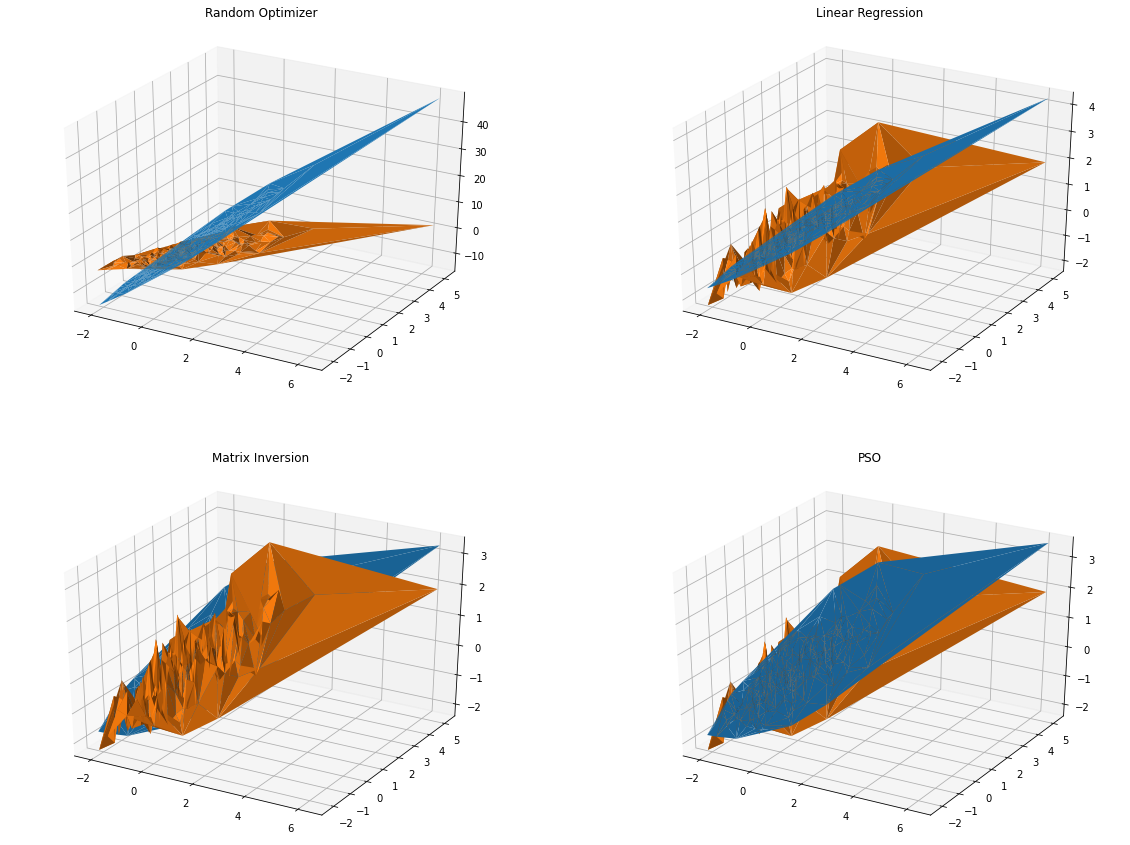

In [104]:
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_trisurf(standard_X[:,0], standard_X[:,1], randomOpt_y_pred)
ax.plot_trisurf(standard_X[:,0], standard_X[:,1], standard_y_true[:,0])
ax.title.set_text('Random Optimizer')

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_trisurf(standard_X[:,0], standard_X[:,1], linearReg_y_pred)
ax.plot_trisurf(standard_X[:,0], standard_X[:,1], standard_y_true[:,0])
ax.title.set_text('Linear Regression')

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot_trisurf(standard_X[:,0], standard_X[:,1], matrixInv_y_pred)
ax.plot_trisurf(standard_X[:,0], standard_X[:,1], standard_y_true[:,0])
ax.title.set_text('Matrix Inversion')

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_trisurf(standard_X[:,0], standard_X[:,1], PSO_y_pred)
ax.plot_trisurf(standard_X[:,0], standard_X[:,1], standard_y_true[:,0])
ax.title.set_text('PSO')

plt.show()